In [43]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import jpholiday
import seaborn as sns
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

# 作業ディレクトリの設定
try:
    os.chdir('H:/マイドライブ/03_code_test/clustering-house_trial')
    data_path_header = 'G:/マイドライブ/01_研究/02_円山町/1_データ前処理'
except FileNotFoundError:
    os.chdir('G:/マイドライブ/03_code_test/clustering-house_trial')
    data_path_header = 'H:/マイドライブ/01_研究/02_円山町/1_データ前処理'
print("Current Working Directory: ", os.getcwd())


# カスタムライブラリのパスを追加
sys.path.append(data_path_header)
from column_translation import column_translation_dict

Current Working Directory:  H:\マイドライブ\03_code_test\clustering-house_trial


In [44]:
csv_path_list = glob.glob('./output_feature/*.csv')
csv_path_list.sort()

df_data = pd.DataFrame()
for csv_path in csv_path_list:
    df_temp = pd.read_csv(csv_path)
    df_temp['house_id'] = int(os.path.basename(csv_path).split('_')[0])
    df_temp['col_name'] = os.path.basename(csv_path).split('_')[1].replace('.csv', '')
    df_data = pd.concat([df_data, df_temp], ignore_index=True)
df_data


,month,total_consumption,PCR,day_night_ratio,weekday_weekend_ratio,consumption_per_active_hour,time_bin_0-6,time_bin_12-18,time_bin_18-24,time_bin_6-12,house_id,col_name
0,2024-04,38.02,4.07,1.67,2.30,80.56,18.22,51.41,38.83,43.61,125,LD
1,2024-05,34.73,3.85,1.51,2.06,73.56,17.78,41.79,37.51,41.83,125,LD
2,2024-06,33.92,4.08,1.34,1.81,70.94,17.96,38.87,40.11,38.74,125,LD
3,2024-07,34.34,3.88,1.45,2.64,73.33,17.88,42.12,38.11,39.27,125,LD
4,2024-08,36.90,4.07,1.48,2.38,77.67,18.66,45.65,40.79,42.50,125,LD
...,...,...,...,...,...,...,...,...,...,...,...,...
175,2024-11,1.01,27.11,11.05,1.39,30.45,0.12,0.68,0.22,3.03,156,washing
176,2024-12,1.08,24.66,7.34,1.93,34.96,0.01,1.40,0.51,2.39,156,washing
177,2025-01,1.17,26.16,11.19,1.26,40.14,0.10,1.81,0.28,2.49,156,washing
178,2025-02,1.03,27.35,6.07,0.92,39.49,0.03,0.96,0.55,2.58,156,washing


In [45]:
from sklearn.impute import SimpleImputer
# 欠損処理
df_dropped = df_data.drop(['month', 'house_id', 'col_name'], axis=1)
df_dropped = df_dropped.replace([np.inf, -np.inf], np.nan).astype("float64")
imp = SimpleImputer(strategy="median")
X = imp.fit_transform(df_dropped)
clean_imputed = pd.DataFrame(X, columns=df_dropped.columns, index=df_dropped.index)
df_features = clean_imputed
# 正規化
mm = preprocessing.MinMaxScaler()
df_features_mm = pd.DataFrame(mm.fit_transform(df_features), columns=df_features.columns)
df_features_mm

,total_consumption,PCR,day_night_ratio,weekday_weekend_ratio,consumption_per_active_hour,time_bin_0-6,time_bin_12-18,time_bin_18-24,time_bin_6-12
0,0.100293,0.078498,0.026777,0.029441,0.105124,0.057422,0.133498,0.081627,0.132934
1,0.091529,0.072241,0.024180,0.025427,0.095944,0.056035,0.108517,0.078837,0.127494
2,0.089371,0.078783,0.021422,0.021245,0.092508,0.056603,0.100935,0.084332,0.118052
3,0.090490,0.073094,0.023207,0.035129,0.095642,0.056350,0.109374,0.080105,0.119671
4,0.097310,0.078498,0.023694,0.030780,0.101334,0.058809,0.118541,0.085769,0.129542
...,...,...,...,...,...,...,...,...,...
175,0.001705,0.733788,0.179000,0.014219,0.039408,0.000378,0.001766,0.000021,0.008923
176,0.001891,0.664107,0.118793,0.023252,0.045323,0.000032,0.003635,0.000634,0.006968
177,0.002131,0.706769,0.181272,0.012044,0.052116,0.000315,0.004700,0.000148,0.007273
178,0.001758,0.740614,0.098182,0.006357,0.051264,0.000095,0.002493,0.000719,0.007548


In [46]:
df_features_mm.columns

Index(['total_consumption', 'PCR', 'day_night_ratio', 'weekday_weekend_ratio',
       'consumption_per_active_hour', 'time_bin_0-6', 'time_bin_12-18',
       'time_bin_18-24', 'time_bin_6-12'],
      dtype='object')

Cluster 0: n = 63
Cluster 1: n = 23
Cluster 2: n = 22
Cluster 3: n = 8
Cluster 4: n = 33
Cluster 5: n = 5
Cluster 6: n = 14
Cluster 7: n = 12


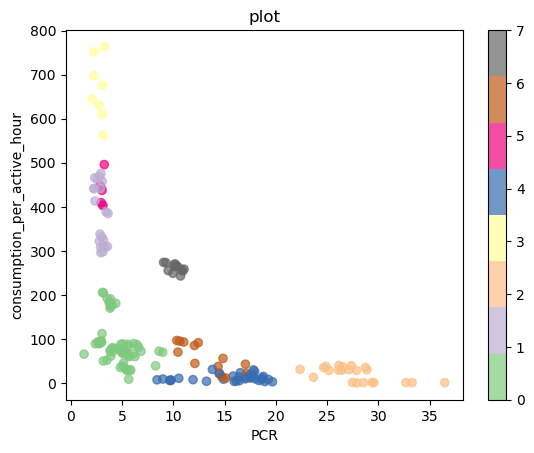

In [47]:
from sklearn.cluster import KMeans

k = 8 # クラスター数を指示

kmeanModel = KMeans(n_clusters=k, random_state=42)
kmeanModel.fit(df_features_mm)
clusters = kmeanModel.labels_

# クラスターごとに何サンプルあるか
for i in range(k):
    num = list(clusters).count(i)
    print(f'Cluster {i}: n = {num}')

plt.scatter(df_features['PCR'], df_features['consumption_per_active_hour'],
            c=clusters, cmap='Accent', alpha=0.7)
plt.title('plot')
plt.xlabel('PCR')
plt.ylabel('consumption_per_active_hour')
plt.colorbar()
plt.show()


In [48]:
from sklearn.decomposition import PCA
pca = PCA(random_state=42)
pca.fit(df_features_mm)
score = pd.DataFrame(pca.transform(df_features_mm), index=df_features.index)
score

,0,1,2,3,4,5,6,7,8
0,-0.098188,-0.205952,0.038592,-0.044716,0.004242,-0.011111,0.001055,-0.007290,7.375276e-06
1,-0.117308,-0.217927,0.028881,-0.039702,0.000168,-0.016650,0.008582,0.005124,7.420683e-06
2,-0.125714,-0.213877,0.018405,-0.035674,-0.002679,-0.022648,0.009151,0.003099,1.598729e-06
3,-0.120579,-0.217846,0.027815,-0.033320,0.008792,-0.015699,0.007808,-0.000548,-1.035979e-05
4,-0.106005,-0.208328,0.029638,-0.038215,0.005675,-0.016366,0.005321,-0.000091,1.479559e-06
...,...,...,...,...,...,...,...,...,...
175,-0.497233,0.374422,0.054897,0.036294,-0.076565,-0.008302,-0.001766,-0.000442,-5.737615e-06
176,-0.474928,0.302769,0.018287,0.014073,-0.044788,0.002196,-0.006108,0.000158,6.132500e-06
177,-0.484400,0.349951,0.055786,0.041831,-0.082091,-0.000361,-0.006299,-0.002397,1.176791e-07
178,-0.492151,0.374358,-0.008328,-0.005096,-0.050507,0.007626,-0.012005,0.002661,-2.646288e-08


In [49]:
from sklearn.preprocessing import LabelEncoder

clusters_str = df_data['col_name']
# 文字列 → 数値に変換
le = LabelEncoder()
clusters_col = le.fit_transform(clusters_str)
list_clusters_col = list(set(le.classes_))
print(list_clusters_col)

clusters_str = df_data['house_id'].astype(str)
# 文字列 → 数値に変換
le = LabelEncoder()
clusters_house = le.fit_transform(clusters_str)
list_clusters_house = list(set(le.classes_))

print(list_clusters_house)


['bedroom', 'kitchen', 'LD', 'dishwasher', 'washing', 'electric']
['125', '156', '147']


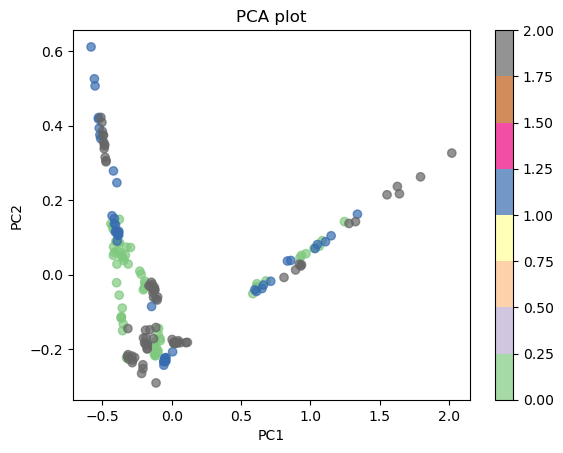

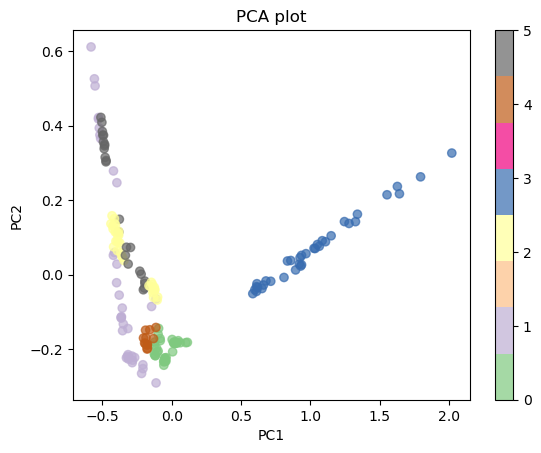

In [50]:
plt.scatter(score.iloc[:,0], score.iloc[:,1],
            c=clusters_house, cmap='Accent', alpha=0.7)
plt.title('PCA plot')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

plt.scatter(score.iloc[:,0], score.iloc[:,1],
            c=clusters_col, cmap='Accent', alpha=0.7)
plt.title('PCA plot')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

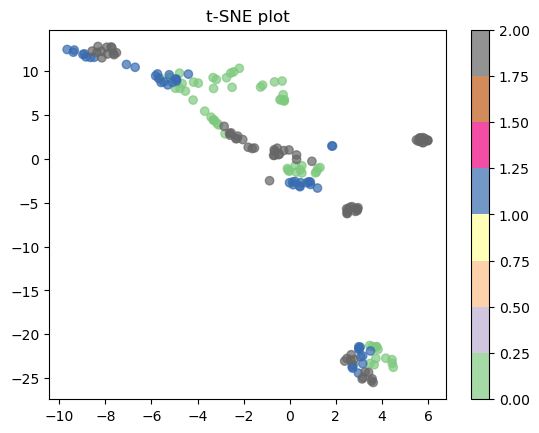

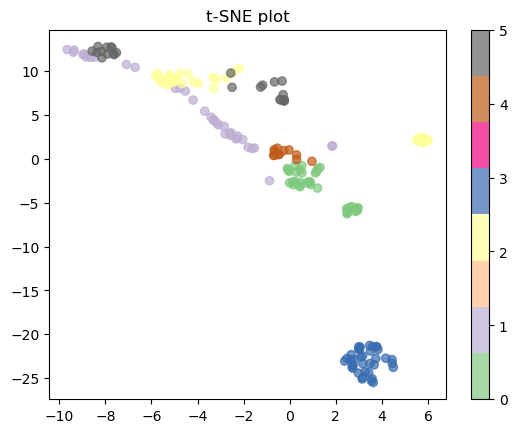

In [51]:
from sklearn.manifold import TSNE
embedding = TSNE(random_state=42).fit_transform(df_features_mm)
plt.scatter(embedding[:, 0], embedding[:, 1],
    c=clusters_house, cmap='Accent', alpha=0.7)
plt.title('t-SNE plot')
plt.colorbar()
plt.show()

plt.scatter(embedding[:, 0], embedding[:, 1],
    c=clusters_col, cmap='Accent', alpha=0.7)
plt.title('t-SNE plot')
plt.colorbar()
plt.show()

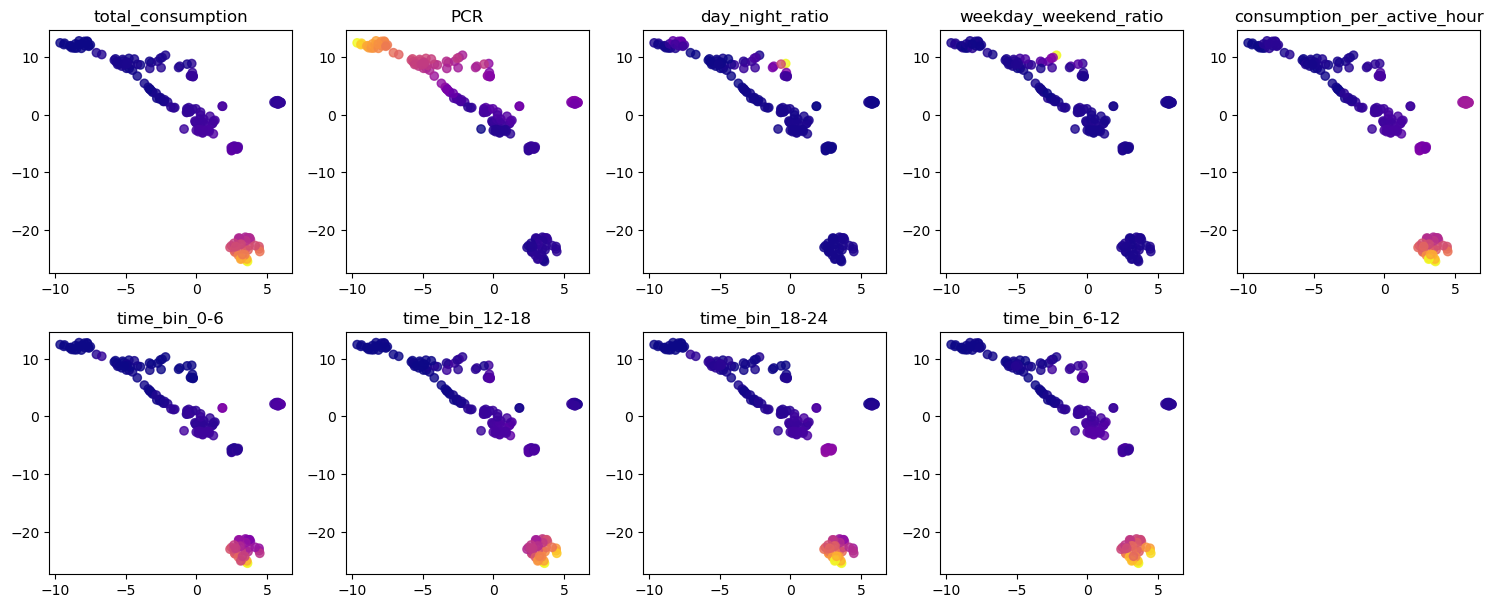

In [52]:
fig = plt.figure(figsize=(15,15))
cols = df_features.columns
for i, col in enumerate(cols):
    ax = fig.add_subplot(5, 5, i+1, title=col)
    ax.scatter(embedding[:, 0], embedding[:, 1],
        c=df_features[col], cmap='plasma', alpha=0.8)
fig.tight_layout()
plt.show()

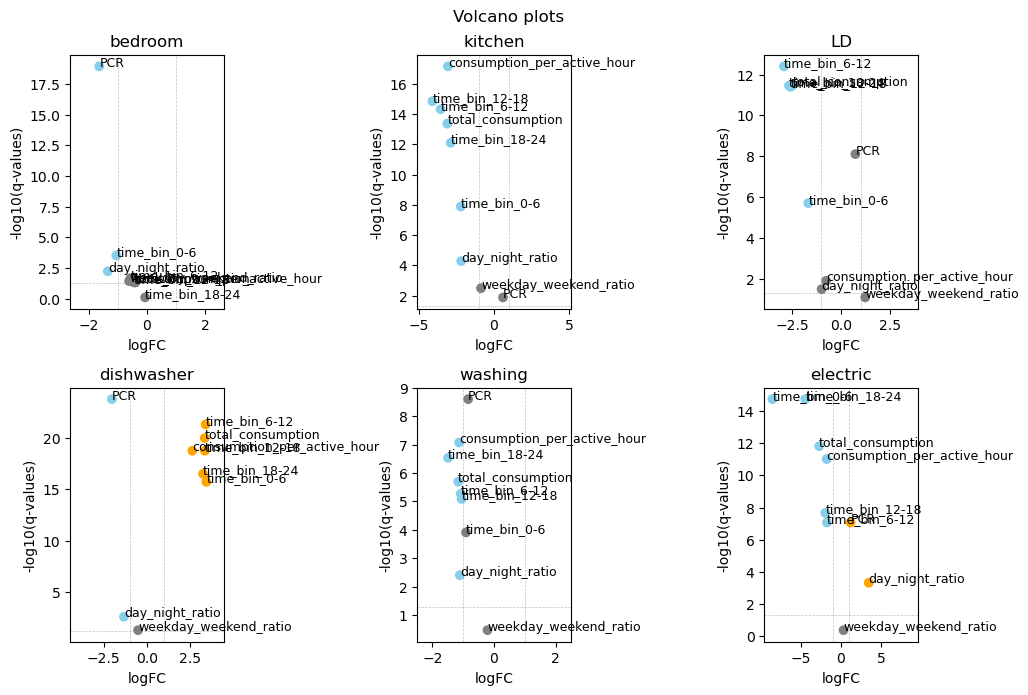

In [ ]:
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

df_features_with_clusters = df_features.copy()
df_features_with_clusters['cluster'] = clusters_col
cols = df_features.columns

# 閾値を定める。ここでは補正後のp値 (q値) が0.05以下かつ数値の比 (Fold Change:fc)が2倍以上あるか、を閾値とします。
q_threshold = 0.05
fc_threshold = 2

fig = plt.figure(figsize=(10,10))
# クラスターごとに評価する
for i in range(len(set(clusters_col))):
    p_values = []
    fcs = []
    # 変数 = プロット上の1点
    for col in cols:
        # 検定
        group_1 = df_features_with_clusters[df_features_with_clusters['cluster'] == i][col]
        group_2 = df_features_with_clusters[df_features_with_clusters['cluster'] != i][col]
        p_value = stats.ttest_ind(group_1, group_2, equal_var=False)[1]
        p_values.append(p_value)

        # Fold change. 平均での比較が不適切であればここをmedian等に変える
        fc = group_1.mean()/group_2.mean()
        fcs.append(fc)

    # p-valueの補正
    q_values = multipletests(p_values, method='fdr_bh')[1]

    # 閾値を超えたものは色を変える
    colors = []
    for col, q_value, fc in zip(cols, q_values, fcs):
        # 対象がその他の2倍大きいときはオレンジ
        if q_value < q_threshold and fc > fc_threshold:
            colors.append('orange')
        # その他が対象の2倍大きいときは水色
        elif q_value < q_threshold and fc < 1/fc_threshold:
            colors.append('skyblue')
        # 大きな違いがない場合は灰色
        else:
            colors.append('gray')

    ax = fig.add_subplot(3,3,i+1)
    ax.scatter(np.log2(fcs), -np.log10(q_values),
    c=colors)

    # 図をきれいに見せるためのあれこれ。好みの世界
    max_val = max(abs(np.nanmin(np.log2(fcs)[np.log2(fcs) != -np.inf])), max(np.log2(fcs)))
    ax.set_xlim([-max_val-1, max_val+1]) # -infがあるので。-inf = そのクラスターでは全員が0
    ax.set_ylim(ax.get_ylim())
    # 閾値に点線をつける
    ax.hlines([-np.log10(q_threshold)], -max_val-1, max_val+1, 'gray', 'dashed', linewidth=0.5, alpha=0.5)
    ax.vlines([np.log2(fc_threshold), np.log2(1/fc_threshold)], ax.get_ylim()[0], ax.get_ylim()[1], 'gray', 'dashed', linewidth=0.5, alpha=0.5)

    # ラベルとアノテーション
    ax.set_title(f'{list_clusters_col[i]}')
    ax.set_xlabel('logFC')
    ax.set_ylabel('-log10(q-values)')
    for j, label in enumerate(cols):
        ax.annotate(label, (np.log2(fcs)[j], -np.log10(q_values)[j]), size=9)

fig.suptitle('Volcano plots')
fig.tight_layout()
plt.show()